#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

#import os.path
import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [2]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [11]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

In [4]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.15]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### Load Active optics relevant data

In [2]:
# Number of bending modes
n_bm = 27
# Relative RBM:BM weighting
rho_bm = 0.1

# Calibrations data
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)

# Bending modes' data
Afz = {}
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
# OA segment weights
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
W_m1oaBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
W_m1oaBM =  rho_bm*(1/np.linalg.norm(W_m1oaBM))*W_m1oaBM
# CS (center segment) weights
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
W_m1csBM = np.diag([1]*n_bm) #np.diag(1/s[:n_bm])
W_m1csBM =  rho_bm*(1/np.linalg.norm(W_m1csBM))*W_m1csBM


# Max actuator command values
max_m1Txyz = [3.0e-3,4.75e-3,4e-3]
max_m1Rxyz = [6.5e-4,5.75e-4,5.75e-4]
max_m2Txyz = [ik*1 for ik in [3.0e-5,3.0e-5,3.0e-5]] 
max_m2Rxyz = [ik*1 for ik in [3.5e-3,3.5e-3,3.5e-3]]
max_Fz = 140

W_M1TxyzRxyz = np.diag(1/np.array(max_m1Txyz + max_m1Rxyz))
W_M2TxyzRxyz = np.diag(1/np.array(max_m2Txyz + max_m2Rxyz))
W_rbm = block_diag(W_M1TxyzRxyz, W_M2TxyzRxyz)
# Rescale RBM weighting matrix
W_rbm = (1/np.linalg.norm(W_rbm))*W_rbm

W2_oa = block_diag(W_rbm,W_m1oaBM)
W2_cs = block_diag(W_rbm,W_m1csBM)
W2 = block_diag(np.kron(np.eye(6),W2_oa),W2_cs)
W2 = W2/np.linalg.norm(W2)

# Print reconstructor regularization weights
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
w__, _w_, __w = np.split(np.reshape(np.diag(W2),[7,39]),[12,39],axis=1)
print('OA BM weights:\n',_w_[0,:])
print('CS BM weights:\n',_w_[-1,:])
print('M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):\n',w__[0,:])

np.set_printoptions(formatter=None)

#np.linalg.norm(dt['calibdt'][()]['D'][0][:12])
#np.linalg.norm(dt['calibdt'][()]['D'][0][12:12+n_bm])

OA BM weights:
 [ 0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072
  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072
  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072]
CS BM weights:
 [ 0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072
  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072
  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0072]
M1/2 RBM weights (M1/TxyzRxyz - M2/TxyzRxyz):
 [ 0.0022  0.0014  0.0016  0.0100  0.0113  0.0113  0.2168  0.2168  0.2168
  0.0019  0.0019  0.0019]


In [3]:
W2=W2_oa

#### AcO reconstructor+controller settings

In [4]:
# MPC settings

# Plant dynamic model matrices
A = np.zeros((84+7*n_bm,84+7*n_bm))
B = np.identity(84+7*n_bm)
nx, nu = A.shape[0], B.shape[1]

# Prediction horizon
npred = 2
# Weighting matrices
Q = np.eye(nx)
R = 5*np.kron(np.eye(7),block_diag(np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*6)),
                                   np.diag(np.array([1]*n_bm))))
print(np.linalg.norm(Q),np.linalg.norm(R))


bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])
rbm_ranges = max_m1Txyz+max_m1Rxyz+max_m2Txyz+max_m2Rxyz
oa_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_oa)]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [max_Fz/np.linalg.norm(bm2Fz_cs)]*bm2Fz_cs.shape[0])

umax = np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) # np.array([]) #
umin = -umax
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),bm2Fz_oa/np.linalg.norm(bm2Fz_cs))),
                 block_diag(np.eye(12),bm2Fz_cs/np.linalg.norm(bm2Fz_cs)))
# AcO dictionary
data = {'SHAcO':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                 'wfsMask':dt['calibdt'][()]['wfsMask'],
                 'A':A,'B':B,
                 'Q':sparse.csc_matrix(Q),'R':sparse.csc_matrix(R),'npred':npred,
                 'umin':umin, 'umax':umax,'_Tu':_Tu}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    
# dictionary for debug
data = {'SHAcO_debug':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                       'wfsMask':dt['calibdt'][()]['wfsMask'],
                       'A':A,'B':B}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO_debug.pickle','wb') as f:
    pickle.dump(data,f)

16.522711641858304 82.61355820929153


In [5]:
s_oa[0], s_oa[n_bm], np.linalg.norm(bm2Fz_oa)

(2.2991212661692033e-06, 1.3893394115550581e-08, 173440625.68788144)

#### Set initial M1/M2 states and generate respective yaml files

In [15]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

#test_case = 's1_curvature_error' <-- Replace by random
test_case = 'BM_dist'

if 'm1_x0_dt' in locals():
    del m1_x0_dt
if 'm2_x0_dt' in locals():
    del m2_x0_dt    

if(test_case == 's1_curvature_error'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
#        
elif(test_case == 'fully_aligned'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
#        
elif(test_case == 'BM_dist'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m1_x0_dt['state']['modes'][0][1] = 5.0e-4
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
    
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)        

#### Instantiate DOS

In [16]:
sim = dos.DOS(sim_folder,verbose=logging.WARNING,show_timing=2)

INFO:wfs48 data:Linked to data from wfs48
INFO:M1 Txyz:Linked to Txyz from M1
INFO:M1 Rxyz:Linked to Rxyz from M1
INFO:M2 Txyz:Linked to Txyz from M2
INFO:M2 Rxyz:Linked to Rxyz from M2
INFO:M1 BM:Linked to modes from M1
INFO:wfs48 data:Linked to data from wfs48


SIMCEO server received: Acknowledging connection from SIMCEO client!
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
Absolute constraints introduced to the MPC
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
Dimension of Dsh: (7360, 273)


In [17]:
# Start simulation
#sim.start()
sim._run_()

27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:1.75653919
-> J1:0.00000000, J3:0.00000000, ratio:1.08871735
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:1.20312563
-> J1:0.00000000, J3:0.00000000, ratio:0.90431905
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:3.56067797
-> J1:0.00000000, J3:0.00000000, ratio:0.71424911
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:5.07934518
-> J1:0.00000000, J3:0.00000000, ratio:0.79913878
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:6.27866022
-> J1:0.00000000, J3:0.00000000, ratio:0.82003624
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:7.44706305
-> J1:0.00000000, J3:0.00000000, ratio:0.76398229
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:8.57879358
-> J1:0.00000000, J3:0.00000000, ratio:0.69441190
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.40261349
-> J1:0.00000000, J3:0.00000000, ratio:0.65323114
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98211429
-> J1:0.00000000, J3:0.00000000, ratio:0.63667841
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.33501466
-> J1:0.00000000, J3:0.00000000, ratio:0.63311897
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.48976897
-> J1:0.00000000, J3:0.00000000, ratio:0.62855624
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.50111831
-> J1:0.00000000, J3:0.00000000, ratio:0.60572271
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.43072259
-> J1:0.00000000, J3:0.00000000, ratio:0.57699825
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.33148534
-> J1:0.00000000, J3:0.00000000, ratio:0.56133605
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.23473416
-> J1:0.00000000, J3:0.00000000, ratio:0.55980005
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.15321965
-> J1:0.00000000, J3:0.00000000, ratio:0.56879360
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.09036503
-> J1:0.00000000, J3:0.00000000, ratio:0.58438669
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.04556974
-> J1:0.00000000, J3:0.00000000, ratio:0.60337887
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.01521751
-> J1:0.00000000, J3:0.00000000, ratio:0.62344594
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.99685242
-> J1:0.00000000, J3:0.00000000, ratio:0.64315442
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98706997
-> J1:0.00000000, J3:0.00000000, ratio:0.66173707
27 BMs used in the reconstructor computation.


No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98336627
-> J1:0.00000000, J3:0.00000000, ratio:0.67894179
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98341261
-> J1:0.00000000, J3:0.00000000, ratio:0.69481830
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98558767
-> J1:0.00000000, J3:0.00000000, ratio:0.70959890
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.98848918
-> J1:0.00000000, J3:0.00000000, ratio:0.72357432
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:9.99159506
-> J1:0.00000000, J3:0.00000000, ratio:0.73703858
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.0000000

No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.00051119
-> J1:0.00000000, J3:0.00000000, ratio:0.81767163
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.00048286
-> J1:0.00000000, J3:0.00000000, ratio:0.83189022
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
+> J1:0.00000000, J3:0.00000000, ratio:10.00055068
-> J1:0.00000000, J3:0.00000000, ratio:0.84638248
Elapsed time: 64.84536409378052


In [6]:
sim.pctComplete

100

### Image quality metrics

In [23]:
sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]

array([7.90571357e-06, 7.71736230e-10, 7.71736453e-10, 7.71906428e-10,
       7.71736397e-10, 7.71736175e-10, 1.72432388e-10])

 #### MPC w/o saturation

 #### Baseline reconstructor & MPC with saturation


Final values:
 WFE: [ 2720107.5573] 
 [ 963650.6438  0.7718  0.7719  0.7719  0.7724  0.7729  0.1724] 
PSSn: [ 0.8006] 
sum of abs seg piston: 7667.084459872843 
 [-7667.0828  0.0001 -0.0001 -0.0000 -0.0009  0.0001  0.0005]


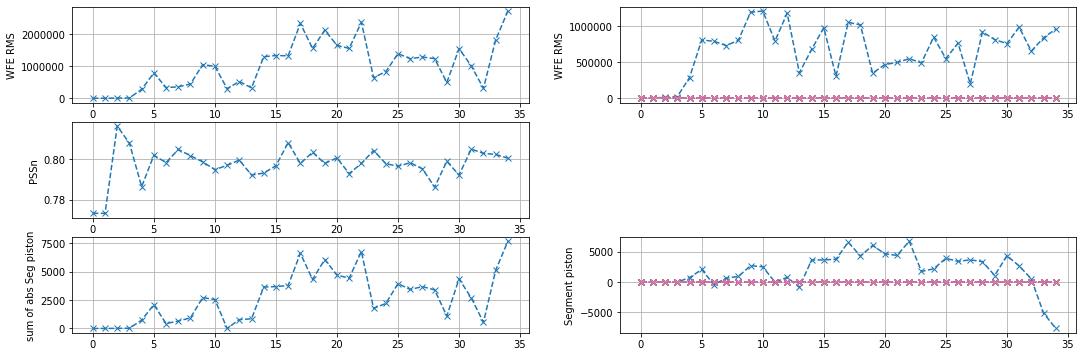

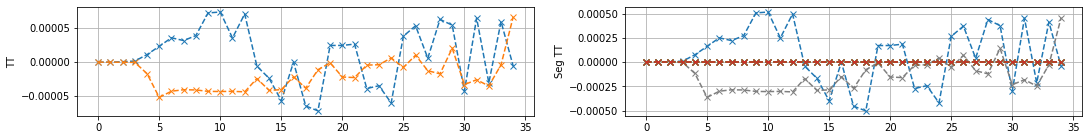

In [18]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [8864.93398866] 
 [125.70431807   0.77154882   0.77201412   0.77203377   0.77194773
   0.77185203   0.1724428 ] 
PSSn: [0.99960351] 
sum of abs seg piston (um): 25.167287100870407 
 [-2.51653873e+01 -9.61497756e-05 -3.33075151e-04 -2.17465004e-04
 -4.88883600e-04 -2.94789387e-04  4.69395967e-04]


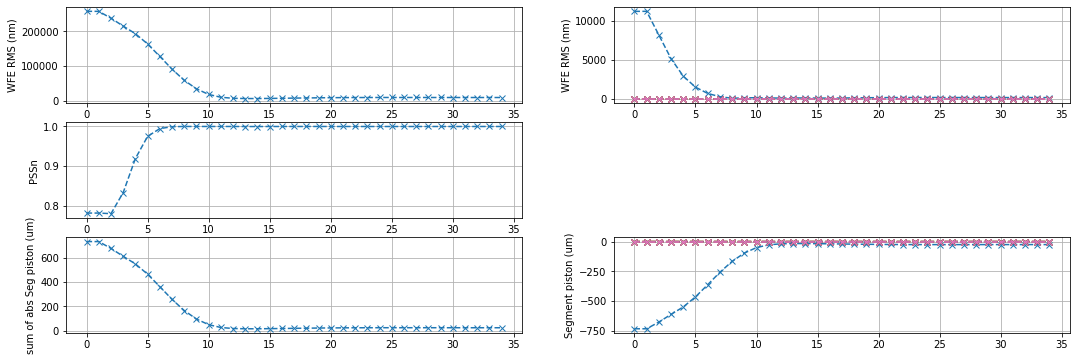

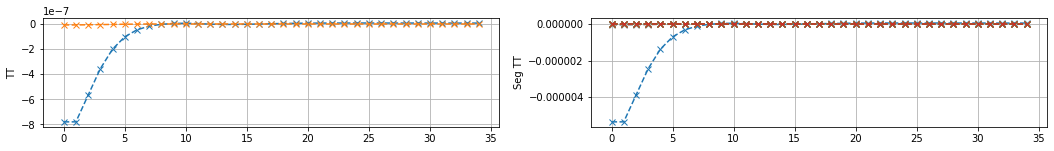

In [18]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Regularized reconstructor & MPC with saturation ($\rho = 1/10$)


Final values:
 WFE (nm): [0.81869073] 
 [0.77158707 0.7717687  0.77185253 0.77198214 0.77248602 0.77304335
 0.17243718] 
PSSn: [1.00000001] 
sum of abs seg piston (um): 0.002087585244427148 
 [-6.29622410e-04  1.18010657e-04 -1.30276567e-04 -2.47770988e-06
 -7.15135617e-04  2.21721010e-05  4.69890182e-04]


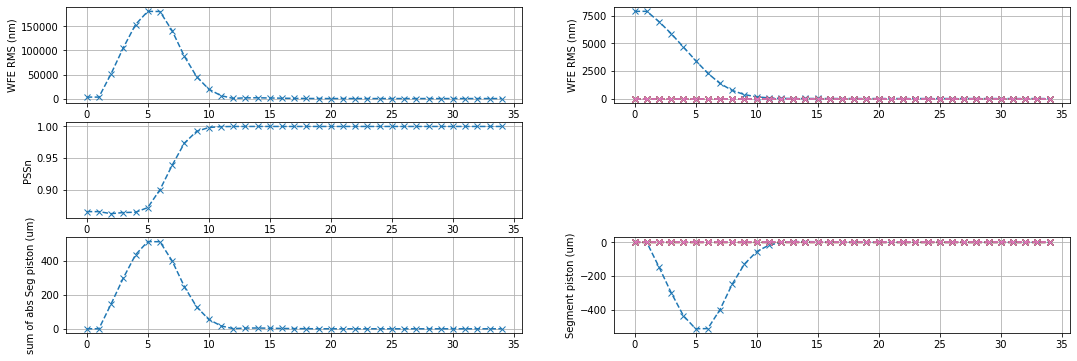

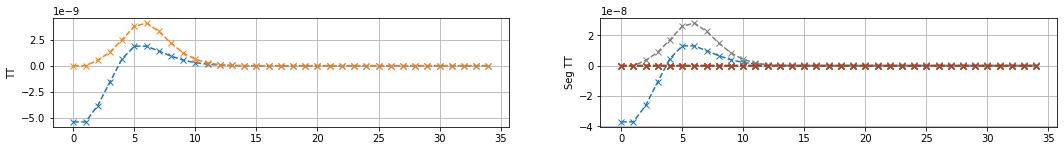

In [9]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [0.81784879] 
 [0.77164708 0.77177903 0.77183726 0.77190276 0.77244372 0.77293488
 0.17243718] 
PSSn: [1.00000004] 
sum of abs seg piston (um): 0.0022861875795254782 
 [-6.26290186e-04 -1.15291124e-04 -1.09486031e-04 -1.07620239e-04
 -8.12678425e-04 -4.49313919e-05  4.69890182e-04]


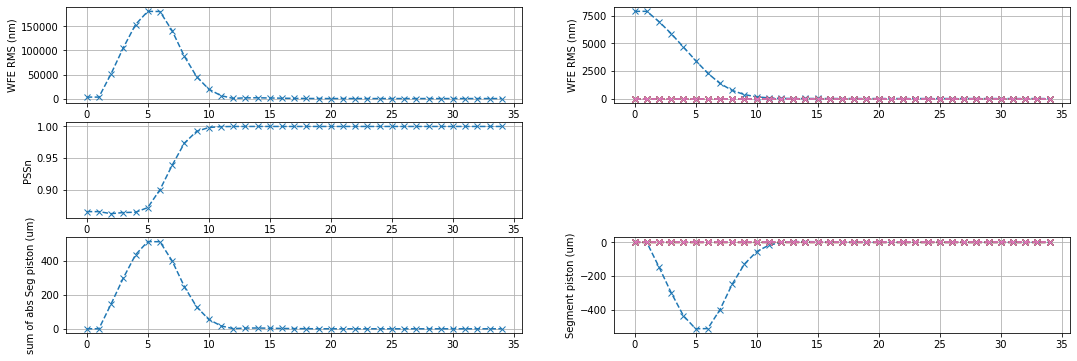

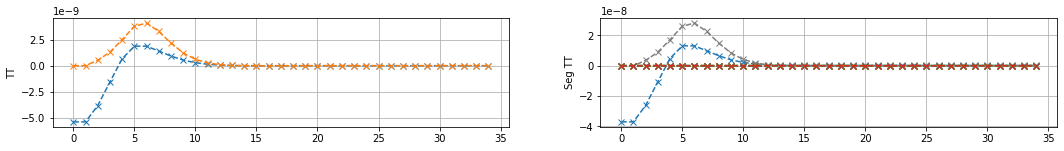

In [24]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Integral controller with saturation

In [ ]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Regularized reconstructor ($\rho = \frac{1}{10}$) & Integral controller with saturation

In [ ]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

 #### MPC w/o saturation

In [ ]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Baseline reconstructor MPC with saturation

In [ ]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Regularized reconstructor & MPC with saturation

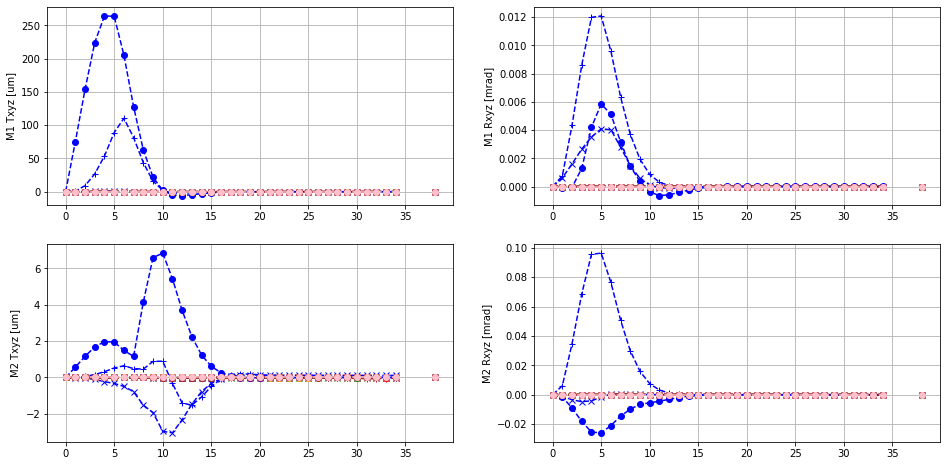

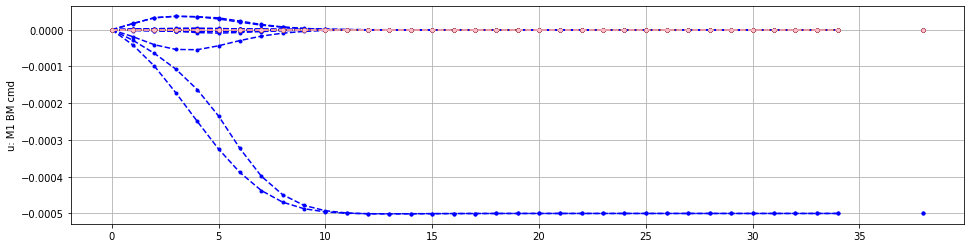

In [10]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [11]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

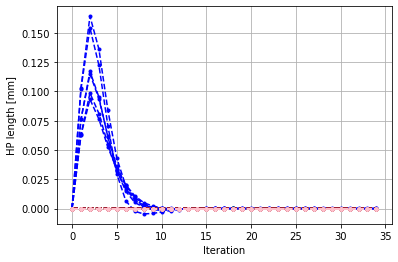

In [12]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

#### Reconstructed states

 #### MPC w/o saturation

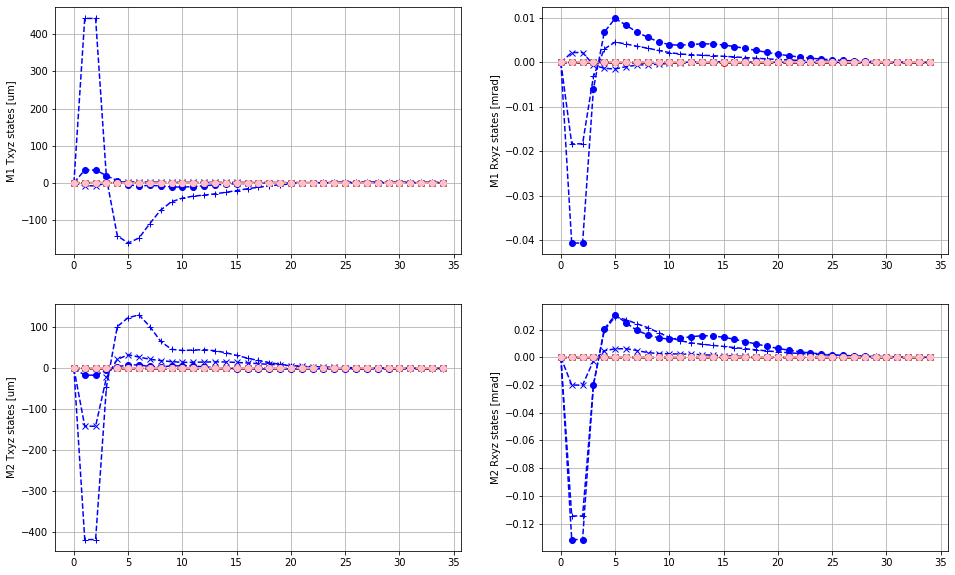

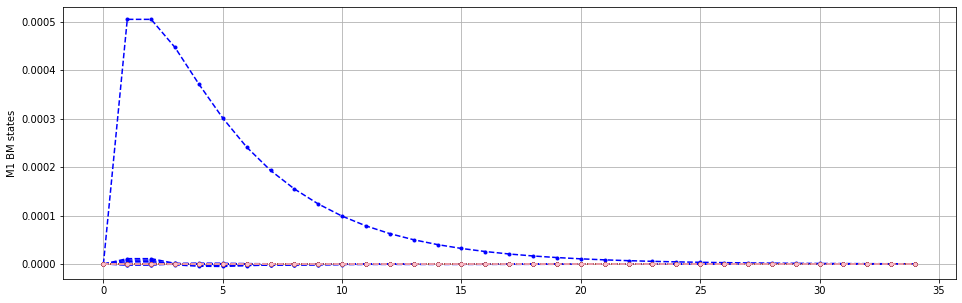

In [12]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

 #### Baseline reconstructor MPC with saturation

In [ ]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

 #### Regularized reconstructor & MPC with saturation

In [ ]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

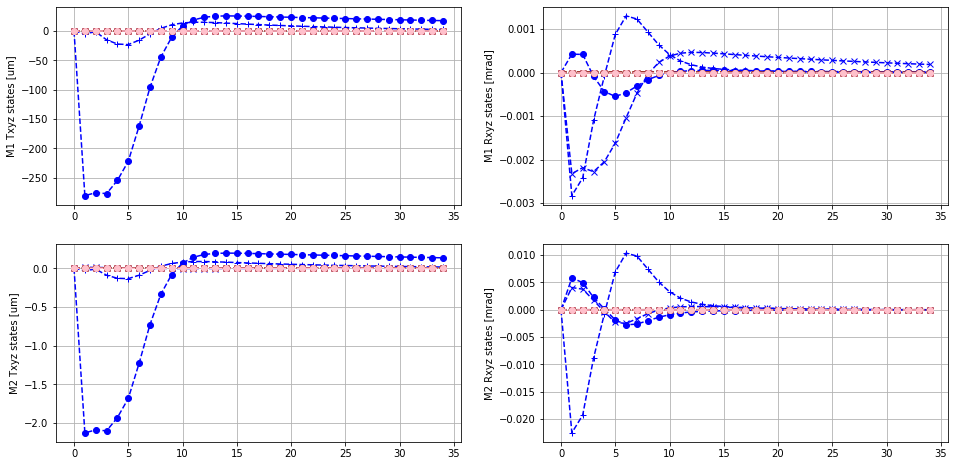

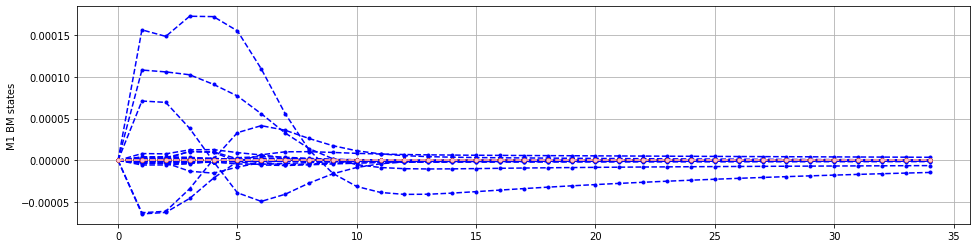

In [13]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

 #### Regularized reconstructor ($\rho = \frac{1}{10}$) & Integral controller with saturation

#### Clutter

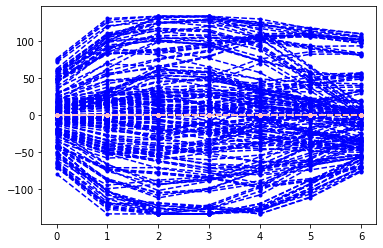

In [14]:
import matplotlib.pyplot as plt

BM = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM[1][kseg,:,1:8]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM[1][6,:,1:8]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM[0].shape),'k')
plt.show()

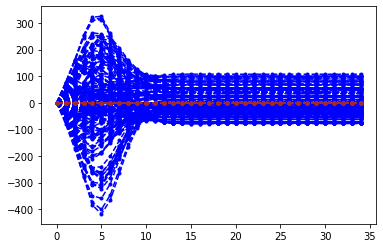

In [9]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM[0].shape),'k')
plt.show()

In [9]:
X_timeseries = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries

isample = X_timeseries[0]
# Indices for M1 states
indX = np.reshape(np.arange(X_timeseries[1].shape[1]), [7, 6 + 6 + n_bm])
i1,i2,i3,i4,i5 = np.split(indX,[3, 6, 9, 12], axis=1)

xM1_Txyz = X_timeseries[1][:,np.reshape(i1,[7,3])]
xM1_Rxyz = X_timeseries[1][:,np.reshape(i2,[7,3])]
xM2_Txyz = X_timeseries[1][:,np.reshape(i3,[7,3])]
xM2_Rxyz = X_timeseries[1][:,np.reshape(i4,[7,3])]
xM1_BM = X_timeseries[1][:,np.reshape(i5,[7,n_bm])]

xM1_Txyz.shape

(35, 7, 3)